# Accurity Data Quality Thresholds

In [3]:
import os
import warnings

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import src.config
from src.utils.tsa import plot_many_ts, plot_one_ts, decompose_ts, stl_arimax_forecast, ets_forecast

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

## 1. Business rule results

Load business rule results data from raw csv file.

In [4]:
brr_raw = pd.read_csv('../data/raw/DQ/business_rule_results.csv', encoding='cp1250', low_memory=False)                     

In [6]:
# Columns selection and renaming
cols = [
    'ID', 'Result Status', 'Name','Trigger Time', 'Passed Threshold', 'Warning Threshold',
    'Goal', 'Records', 'Passed Records', 'Failed Records'
]

brr = brr_raw[cols]
brr.columns = [
    'id', 'result_status', 'name','trigger_time', 'passed_threshold', 'warning_threshold',
    'goal', 'records', 'passed_records', 'failed_records'
]

In [7]:
# Data cleaning and adjustments
def get_numpy_datetime(year, month, day):
    return np.datetime64(f'{year}-{month}-{day}')

brr['year'] = brr['trigger_time'].str[6:10]
brr['month'] = brr['trigger_time'].str[3:5]
brr['day'] = brr['trigger_time'].str[:2]
brr['trigger_date'] = np.vectorize(get_numpy_datetime)(brr['year'], brr['month'], brr['day'])

brr = (brr.astype({'passed_threshold': float, 'warning_threshold': float})
       .drop(columns=['trigger_time', 'day', 'month', 'year'], errors='ignore')
       .assign(failed_records_pct=brr.failed_records/brr.records)
       .assign(passed_records_pct=brr.passed_records/brr.records)
       .query("passed_threshold == 0.05")
       .drop_duplicates(subset=['id', 'trigger_date'])
       .sort_values(['id', 'trigger_date'])
       .set_index('trigger_date', drop=False)
)

brr.index.name = None
print(f"Input BRR dataset has {len(brr):,.0f} observations.")

Input BRR dataset has 289,390 observations.


In [8]:
# Impute missing dates values using linear interpolation
brr = (
    brr.groupby('id')
    .resample('D')
    .interpolate()
    .fillna(method='backfill')
    .reset_index(level=[0], drop=True)
)
print(f"Interpolated BRR dataset has {len(brr):,.0f} observations.")

Interpolated BRR dataset has 297,011 observations.


In [9]:
# Calculate aggregated statistics at ID level & max_passed_records_pct level
brr_stat = (
    brr.groupby('id')
    .agg(max_passed_records_pct=('passed_records_pct', max),
         max_passed_records=('passed_records', max),
         count=('id', 'count'),
         start_date=('trigger_date', min),
         end_date=('trigger_date', max))
    .query("count > 100")
    .reset_index()
)

brr_stat_agg = (
    brr_stat.groupby('max_passed_records_pct')
    .agg(count=('max_passed_records_pct', 'count'))
    .sort_values('count', ascending=False)
    .reset_index()
)

print(f"Total number of business rules with at least 100 days of records: {brr_stat.value_counts().count()}")
print(f"Number of business rules with at least 100 days of records without any failed record: {brr_stat_agg.at[0, 'count']/brr_stat.value_counts().count():,.2%}")

Total number of business rules with at least 100 days of records: 510
Number of business rules with at least 100 days of records without any failed record: 36.47%


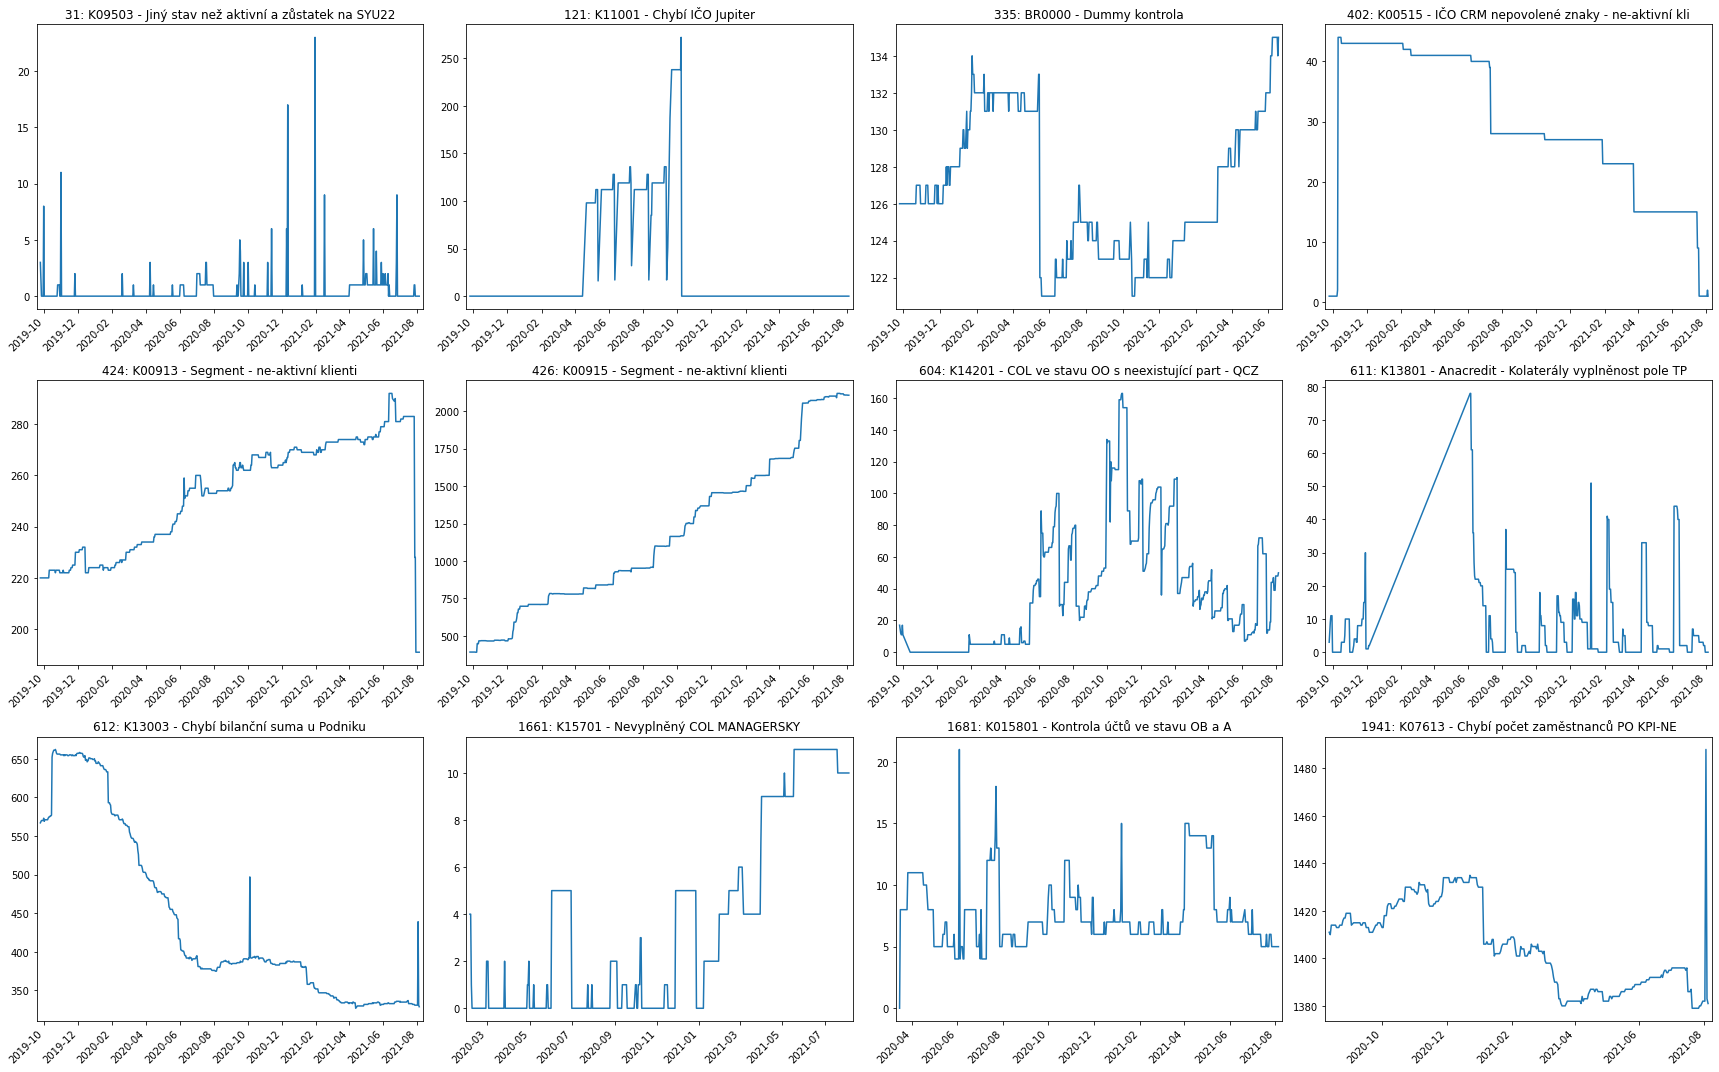

In [69]:
# Generate selected BRR plots
selected_rule_ids = [335, 121, 31, 402, 424, 426, 604, 611, 612, 1681, 1661, 1941, 2421, 2861]

# data = brr[brr.id.isin(brr_stat[brr_stat.max_passed_records > 0].id)]
data = brr[brr.id.isin(selected_rule_ids)]

plot_many_ts(data, y='passed_records', id='id', title='name', nrows=3)

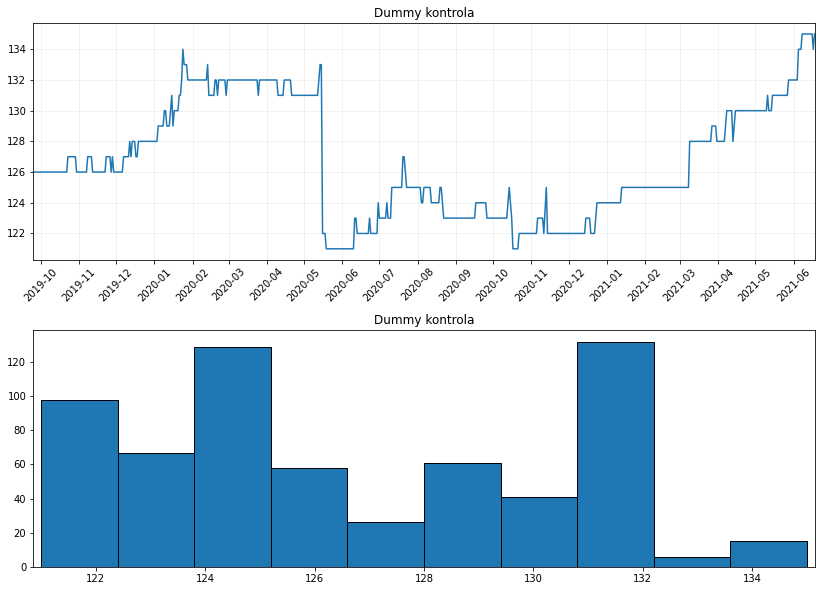

In [11]:
data_335 = data[data.id == 335].rename(columns={'passed_records': 'observed_raw'})['observed_raw']
data_335.index.freq = 'D'

plot_one_ts(y=data_335, title='Dummy kontrola', xticks_freq=1)

,observed,trend,seasonal,residual,seasonally adjusted
2019-09-25,126,126.06,-0.14,0.08,126.14
2019-09-26,126,126.04,-0.07,0.03,126.07
2019-09-27,126,126.02,-0.01,-0.01,126.01
2019-09-28,126,126.01,0.10,-0.11,125.90
2019-09-29,126,126.00,0.09,-0.09,125.91
...,...,...,...,...,...
2021-06-14,135,134.91,0.03,0.07,134.97
2021-06-15,135,134.88,0.07,0.05,134.93
2021-06-16,135,134.86,-0.11,0.25,135.11
2021-06-17,134,134.84,-0.29,-0.55,134.29


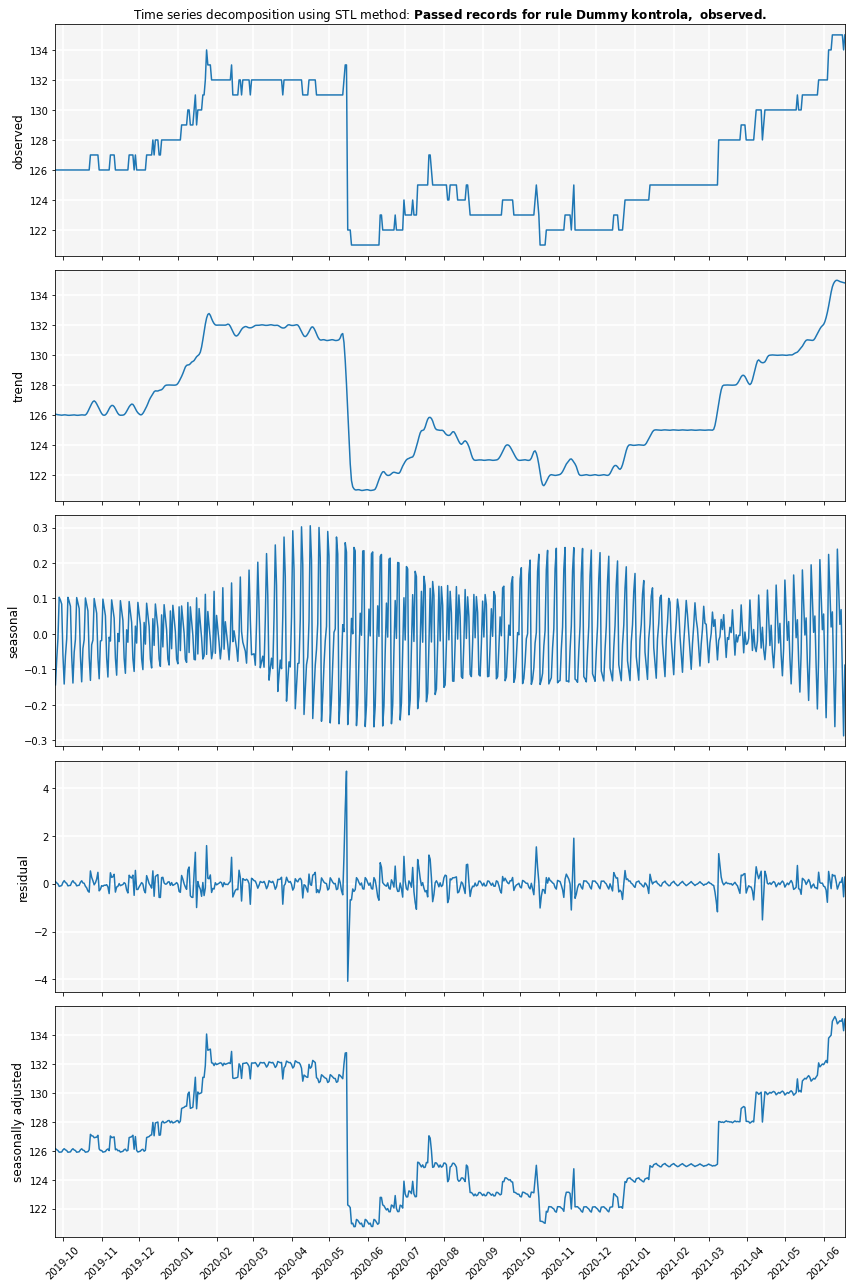

In [25]:
decompose_ts(y=data_335,
              method='stl', 
              period=7, 
              stl_seasonal=33,
              stl_trend_deg=1,
              stl_seasonal_deg=1,
              stl_low_pass_deg=1,
              title='$\mathbf{Passed \ records \ for \ rule \ Dummy \ kontrola, \ observed.}$', 
              xticks_fmt='%Y-%m',
              xticks_freq=1, 
              date_freq='M',
              return_type='both')

AICc= 1201.85
AIC = 1201.78 
MSE = 25.52                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  633
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -596.891
Date:                Mon, 13 Sep 2021   AIC                           1201.782
Time:                        09:39:30   BIC                           1219.578
Sample:                    09-25-2019   HQIC                          1208.693
                         - 06-18-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4349      0.288      1.508      0.132      -0.130       1.000
ar.L2         -0.0540      0.048     -1.129      0.259      -0.148       0.040
ma.L1       

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
residual_acf,0.00,-0.01,0.03,-0.01,-0.01,-0.03,-0.02,-0.03,0.06,0.01,0.02,0.02,0.02,-0.03,-0.03,0.02,0.02,0.03,0.03,0.04
q_stat,0.00,0.09,0.64,0.77,0.82,1.31,1.71,2.47,4.75,4.77,5.17,5.34,5.70,6.13,6.87,7.19,7.42,8.11,8.57,9.52
p_value,0.99,0.96,0.89,0.94,0.98,0.97,0.97,0.96,0.86,0.91,0.92,0.95,0.96,0.96,0.96,0.97,0.98,0.98,0.98,0.98


,observed_raw,observed_raw_seasonal_adjusted,predicted_raw,regression_residual,arima_residual,pi_lower_raw,pi_upper_raw
2019-09-25,126,126.14,-0.14,126.14,0.13,-1960.11,1959.82
2019-09-26,126,126.07,126.07,-0.07,-0.11,124.84,127.30
2019-09-27,126,126.01,126.06,-0.06,-0.10,124.84,127.29
2019-09-28,126,125.90,126.13,-0.13,-0.20,124.90,127.35
2019-09-29,126,125.91,126.01,-0.01,-0.01,124.79,127.23


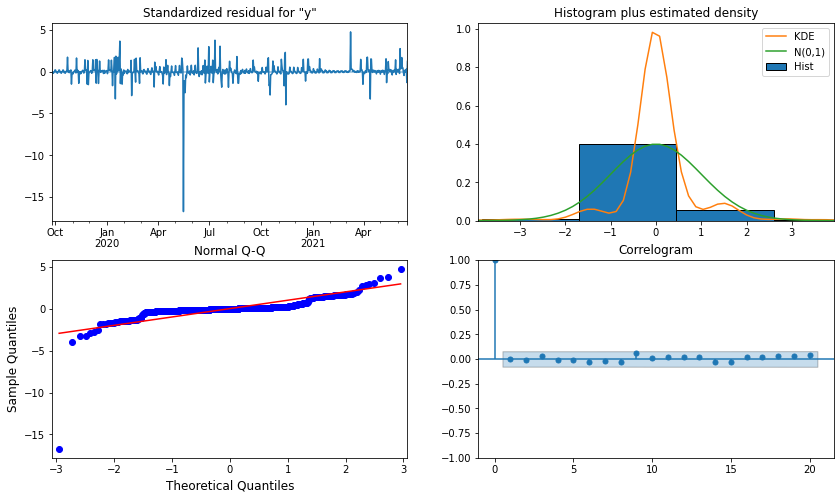

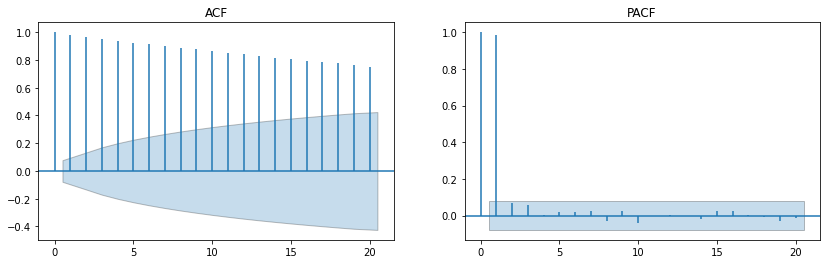

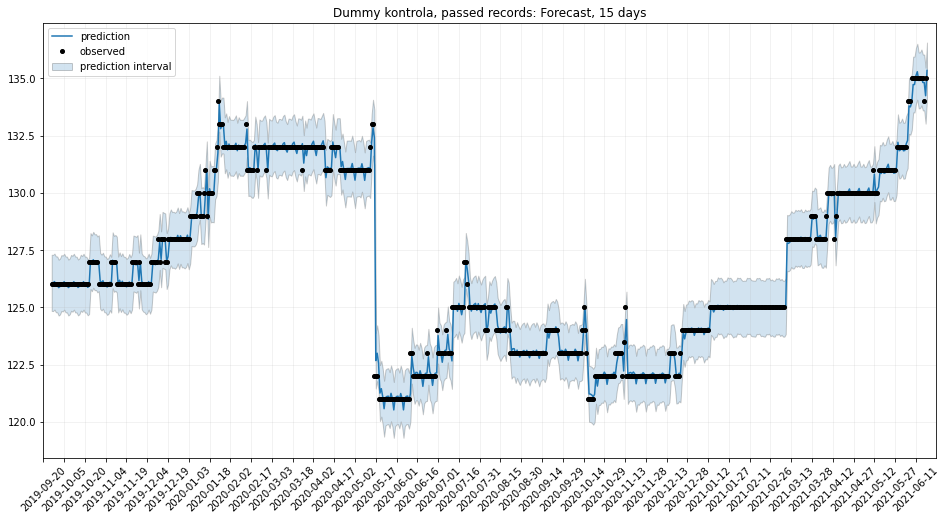

In [17]:
# STL-ARIMAX forecasts
arima_params = {'order': (2, 1, 1), 'trend': 'n'}
forecast_plot_params = {
    'title': f"Dummy kontrola, passed records: Forecast, 15 days", 
    'start_idx': 1, 
    'xticks_freq': 15,
    'date_freq': 'D',
    'date_fmt':'%Y-%m-%d'
}

stl_arimax_forecast(y=data_335,
                    stl_seasonal=33,
                    arima_params=arima_params,
                    forecast_plot_params=forecast_plot_params)

AICc= 51.91
AIC = 50.99 
MSE = 0.26                        Exponential Smoothing Results                         
Dep. Variable:         passed_records   No. Observations:                   30
Model:                   ETS(A, N, N)   Log Likelihood                 -22.494
Date:                Mon, 13 Sep 2021   AIC                             50.988
Time:                        13:18:58   BIC                             55.191
Sample:                    05-20-2021   HQIC                            52.332
                         - 06-18-2021   Scale                            0.262
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.8745      0.256      3.419      0.001       0.373       1.376
initial_level     131.0000   2.07e+06   6.33e-05      1.000   -4.05e+06    4.05e+

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
residual_acf,-0.09,-0.05,0.18,-0.07,-0.10,-0.11,-0.08,0.15,-0.19,0.04,0.03,-0.31,0.16,-0.04,-0.05,-0.05,-0.01,-0.01,-0.03,-0.12
q_stat,0.25,0.34,1.50,1.68,2.10,2.56,2.84,3.80,5.40,5.48,5.53,10.72,12.24,12.35,12.48,12.65,12.66,12.66,12.73,14.03
p_value,0.62,0.84,0.68,0.79,0.84,0.86,0.90,0.87,0.80,0.86,0.90,0.55,0.51,0.58,0.64,0.70,0.76,0.81,0.85,0.83


,passed_records,predicted_raw,regression_residual,arima_residual,pi_lower_raw,pi_upper_raw
2021-06-14,135,135.00,0.00,0.00,133.31,136.69
2021-06-15,135,135.00,0.00,0.00,133.31,136.69
2021-06-16,135,135.00,0.00,0.00,133.31,136.69
2021-06-17,134,135.00,-1.00,-1.95,133.31,136.69
2021-06-18,135,134.13,0.87,1.71,132.44,135.81
2021-06-19,NaN,134.89,NaN,NaN,133.21,136.58
2021-06-20,NaN,134.89,NaN,NaN,132.65,137.13
2021-06-21,NaN,134.89,NaN,NaN,132.21,137.57
2021-06-22,NaN,134.89,NaN,NaN,131.83,137.95
2021-06-23,NaN,134.89,NaN,NaN,131.50,138.29


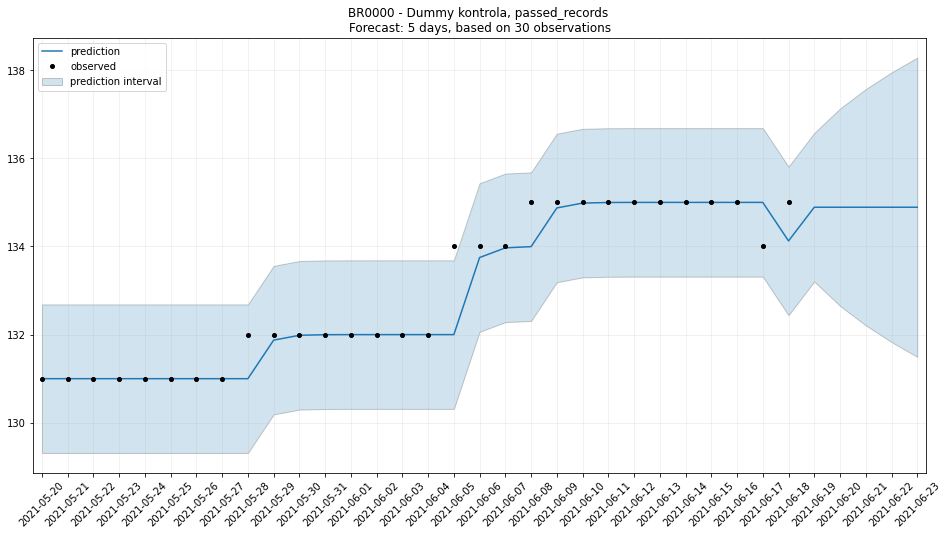

In [93]:
# ETS forecasts
no = 335
data_one = data[data.id == no]

forecast_params = {'steps': 5, 'alpha': 0.001, 'date_freq': 'D', 'last_obs_only': 30}
forecast_plot_params = {'xticks_freq': 1, 'date_freq': 'D', 'date_fmt':'%Y-%m-%d'}

ets_forecast(data=data_one,
             y='passed_records',
             title='name',
             forecast_params=forecast_params, 
             forecast_plot_params=forecast_plot_params
)

In [61]:
os.system('jupyter nbconvert data_quality_thresholds.ipynb \
          --output ../reports/data_quality_thresholds.html \
          --to html \
          --no-prompt \
          --SlidesExporter.reveal_transition=fade');